# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

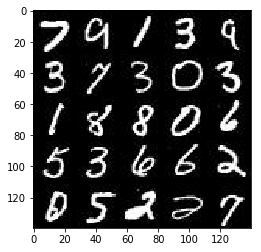

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

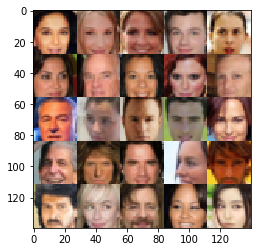

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.02
    with tf.variable_scope("discriminator", reuse=reuse):
        #28x28x3
        conv_1 = tf.layers.conv2d(images, filters=64, kernel_size=4, strides=2, padding='same')
        relu_1 = tf.maximum(alpha * conv_1, conv_1)
        #14x14x64
        conv_2 = tf.layers.conv2d(relu_1, filters=128, kernel_size=4, strides=2, padding='same')
        batch_normalizated_conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2 = tf.maximum(alpha * batch_normalizated_conv_2, batch_normalizated_conv_2)
        #7x7x128
        
        flatten = tf.reshape(relu_2, shape=(-1, 7 * 7 * 128))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        return output, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.02
    with tf.variable_scope("generator", reuse=not is_train):
        fully_connected_layer_1 = tf.layers.dense(z, units=7 * 7 * 128)
        reshaped_fully_connected_layer_1 = tf.reshape(fully_connected_layer_1, shape=(-1, 7, 7, 128))
        batch_normalizated_layer_1 = tf.layers.batch_normalization(reshaped_fully_connected_layer_1, training=is_train)
        relu_1 = tf.maximum(alpha * batch_normalizated_layer_1, batch_normalizated_layer_1)
        #7x7x128
        conv_1 = tf.layers.conv2d_transpose(relu_1, filters=64, kernel_size=4, strides=2, padding='same')
        batch_normalizated_conv_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        relu_2 = tf.maximum(alpha * batch_normalizated_conv_1, batch_normalizated_conv_1)
        #14x14x64
        conv_2 = tf.layers.conv2d_transpose(relu_2, filters=32, kernel_size=4, strides=2, padding='same')
        batch_normalizated_conv_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        relu_3 = tf.maximum(alpha * batch_normalizated_conv_2, batch_normalizated_conv_2)
        #28x28x32
        logits = tf.layers.conv2d_transpose(relu_3, filters=out_channel_dim, kernel_size=4, strides=1, padding='same')

        output = tf.tanh(logits)

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_output = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    
    real_image_d_output, real_image_d_logits = discriminator(input_real, reuse=False)
    fake_image_d_output, fake_image_d_logits = discriminator(g_output, reuse=True)
    
    real_image_d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_image_d_logits, labels=tf.ones_like(real_image_d_output) * 0.9)
    )
    
    fake_image_d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_image_d_logits, labels=tf.zeros_like(fake_image_d_output))
    )
    
    d_loss = real_image_d_loss + fake_image_d_loss
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_image_d_logits, labels=tf.ones_like(fake_image_d_output))
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    d_trainable_vars = [var for var in trainable_vars if var.name.startswith("discriminator")]
    g_trainable_vars = [var for var in trainable_vars if var.name.startswith("generator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_trainable_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_trainable_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print_result_iteration = 10
    print_generator_output_iternation = 100
    # Build Model
    
    number_of_images, image_width, image_height, image_channels = data_shape
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % print_result_iteration == 0:
                    train_loss_d_value = sess.run(d_loss, {input_real: batch_images, input_z: batch_z})
                    train_loss_g_value = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Batch {}/{}...".format(steps, number_of_images / batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d_value),
                          "Generator Loss: {:.4f}".format(train_loss_g_value))
                    
                if steps % print_generator_output_iternation == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10/468.75... Discriminator Loss: 0.6318... Generator Loss: 1.5064
Epoch 1/2... Batch 20/468.75... Discriminator Loss: 0.6470... Generator Loss: 1.5391
Epoch 1/2... Batch 30/468.75... Discriminator Loss: 0.8747... Generator Loss: 1.2556
Epoch 1/2... Batch 40/468.75... Discriminator Loss: 0.9396... Generator Loss: 1.1669
Epoch 1/2... Batch 50/468.75... Discriminator Loss: 0.7624... Generator Loss: 1.8162
Epoch 1/2... Batch 60/468.75... Discriminator Loss: 0.7666... Generator Loss: 1.2523
Epoch 1/2... Batch 70/468.75... Discriminator Loss: 0.7662... Generator Loss: 1.2920
Epoch 1/2... Batch 80/468.75... Discriminator Loss: 0.8806... Generator Loss: 1.5018
Epoch 1/2... Batch 90/468.75... Discriminator Loss: 0.9787... Generator Loss: 0.9503
Epoch 1/2... Batch 100/468.75... Discriminator Loss: 1.0152... Generator Loss: 1.1813


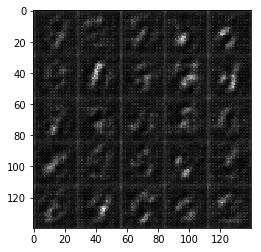

Epoch 1/2... Batch 110/468.75... Discriminator Loss: 1.0233... Generator Loss: 1.2029
Epoch 1/2... Batch 120/468.75... Discriminator Loss: 1.0362... Generator Loss: 1.1971
Epoch 1/2... Batch 130/468.75... Discriminator Loss: 1.0395... Generator Loss: 1.1241
Epoch 1/2... Batch 140/468.75... Discriminator Loss: 1.0460... Generator Loss: 0.9567
Epoch 1/2... Batch 150/468.75... Discriminator Loss: 1.1435... Generator Loss: 1.4915
Epoch 1/2... Batch 160/468.75... Discriminator Loss: 1.0485... Generator Loss: 1.1640
Epoch 1/2... Batch 170/468.75... Discriminator Loss: 1.0261... Generator Loss: 1.1142
Epoch 1/2... Batch 180/468.75... Discriminator Loss: 1.0413... Generator Loss: 1.1549
Epoch 1/2... Batch 190/468.75... Discriminator Loss: 1.0326... Generator Loss: 1.2802
Epoch 1/2... Batch 200/468.75... Discriminator Loss: 1.0068... Generator Loss: 1.0311


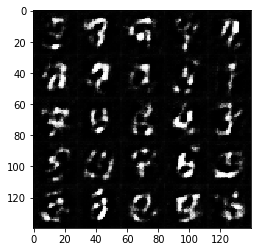

Epoch 1/2... Batch 210/468.75... Discriminator Loss: 1.0287... Generator Loss: 0.8672
Epoch 1/2... Batch 220/468.75... Discriminator Loss: 1.0158... Generator Loss: 0.9707
Epoch 1/2... Batch 230/468.75... Discriminator Loss: 1.0618... Generator Loss: 0.8388
Epoch 1/2... Batch 240/468.75... Discriminator Loss: 1.0496... Generator Loss: 1.0247
Epoch 1/2... Batch 250/468.75... Discriminator Loss: 0.8995... Generator Loss: 1.4022
Epoch 1/2... Batch 260/468.75... Discriminator Loss: 0.7859... Generator Loss: 1.5036
Epoch 1/2... Batch 270/468.75... Discriminator Loss: 0.9010... Generator Loss: 1.2991
Epoch 1/2... Batch 280/468.75... Discriminator Loss: 0.9872... Generator Loss: 0.9701
Epoch 1/2... Batch 290/468.75... Discriminator Loss: 0.8617... Generator Loss: 1.3653
Epoch 1/2... Batch 300/468.75... Discriminator Loss: 0.8785... Generator Loss: 1.4743


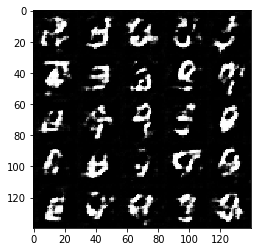

Epoch 1/2... Batch 310/468.75... Discriminator Loss: 0.9188... Generator Loss: 1.3691
Epoch 1/2... Batch 320/468.75... Discriminator Loss: 0.9122... Generator Loss: 1.0242
Epoch 1/2... Batch 330/468.75... Discriminator Loss: 0.9073... Generator Loss: 1.4016
Epoch 1/2... Batch 340/468.75... Discriminator Loss: 0.9141... Generator Loss: 1.0184
Epoch 1/2... Batch 350/468.75... Discriminator Loss: 0.9088... Generator Loss: 1.5499
Epoch 1/2... Batch 360/468.75... Discriminator Loss: 0.9983... Generator Loss: 1.9870
Epoch 1/2... Batch 370/468.75... Discriminator Loss: 0.8568... Generator Loss: 1.4918
Epoch 1/2... Batch 380/468.75... Discriminator Loss: 0.8908... Generator Loss: 1.3188
Epoch 1/2... Batch 390/468.75... Discriminator Loss: 0.8644... Generator Loss: 1.0953
Epoch 1/2... Batch 400/468.75... Discriminator Loss: 0.8490... Generator Loss: 1.3136


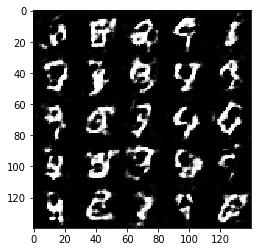

Epoch 1/2... Batch 410/468.75... Discriminator Loss: 0.8657... Generator Loss: 1.3676
Epoch 1/2... Batch 420/468.75... Discriminator Loss: 0.9484... Generator Loss: 0.9674
Epoch 1/2... Batch 430/468.75... Discriminator Loss: 0.8501... Generator Loss: 1.4909
Epoch 1/2... Batch 440/468.75... Discriminator Loss: 0.8855... Generator Loss: 1.1026
Epoch 1/2... Batch 450/468.75... Discriminator Loss: 0.8505... Generator Loss: 1.5225
Epoch 1/2... Batch 460/468.75... Discriminator Loss: 0.9273... Generator Loss: 0.9911
Epoch 2/2... Batch 10/468.75... Discriminator Loss: 0.8752... Generator Loss: 1.4391
Epoch 2/2... Batch 20/468.75... Discriminator Loss: 0.7959... Generator Loss: 1.3657
Epoch 2/2... Batch 30/468.75... Discriminator Loss: 0.8524... Generator Loss: 1.4778
Epoch 2/2... Batch 40/468.75... Discriminator Loss: 0.9091... Generator Loss: 1.5868
Epoch 2/2... Batch 50/468.75... Discriminator Loss: 0.8820... Generator Loss: 1.5735
Epoch 2/2... Batch 60/468.75... Discriminator Loss: 0.8733.

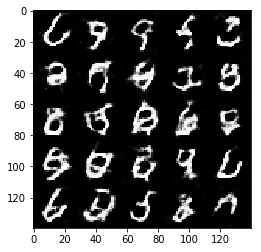

Epoch 2/2... Batch 110/468.75... Discriminator Loss: 0.9007... Generator Loss: 1.1979
Epoch 2/2... Batch 120/468.75... Discriminator Loss: 0.9604... Generator Loss: 1.2948
Epoch 2/2... Batch 130/468.75... Discriminator Loss: 0.9950... Generator Loss: 0.9255
Epoch 2/2... Batch 140/468.75... Discriminator Loss: 0.9825... Generator Loss: 1.2847
Epoch 2/2... Batch 150/468.75... Discriminator Loss: 0.9931... Generator Loss: 0.9070
Epoch 2/2... Batch 160/468.75... Discriminator Loss: 0.9878... Generator Loss: 1.6084
Epoch 2/2... Batch 170/468.75... Discriminator Loss: 0.9564... Generator Loss: 1.4012
Epoch 2/2... Batch 180/468.75... Discriminator Loss: 0.9677... Generator Loss: 1.6478
Epoch 2/2... Batch 190/468.75... Discriminator Loss: 1.0312... Generator Loss: 1.6347
Epoch 2/2... Batch 200/468.75... Discriminator Loss: 1.0238... Generator Loss: 0.9309


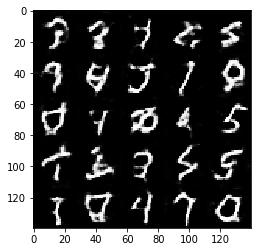

Epoch 2/2... Batch 210/468.75... Discriminator Loss: 0.9454... Generator Loss: 1.1327
Epoch 2/2... Batch 220/468.75... Discriminator Loss: 0.9435... Generator Loss: 1.1821
Epoch 2/2... Batch 230/468.75... Discriminator Loss: 0.9780... Generator Loss: 1.4208
Epoch 2/2... Batch 240/468.75... Discriminator Loss: 1.1144... Generator Loss: 0.7383
Epoch 2/2... Batch 250/468.75... Discriminator Loss: 0.9877... Generator Loss: 0.9838
Epoch 2/2... Batch 260/468.75... Discriminator Loss: 1.0340... Generator Loss: 0.8483
Epoch 2/2... Batch 270/468.75... Discriminator Loss: 0.8939... Generator Loss: 1.1782
Epoch 2/2... Batch 280/468.75... Discriminator Loss: 0.9679... Generator Loss: 0.9838
Epoch 2/2... Batch 290/468.75... Discriminator Loss: 0.9387... Generator Loss: 1.0734
Epoch 2/2... Batch 300/468.75... Discriminator Loss: 0.9903... Generator Loss: 1.6891


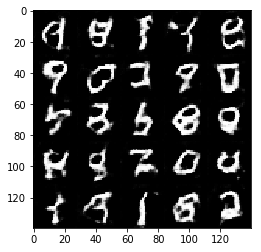

Epoch 2/2... Batch 310/468.75... Discriminator Loss: 0.9465... Generator Loss: 1.4046
Epoch 2/2... Batch 320/468.75... Discriminator Loss: 0.9117... Generator Loss: 1.2016
Epoch 2/2... Batch 330/468.75... Discriminator Loss: 1.0413... Generator Loss: 1.6749
Epoch 2/2... Batch 340/468.75... Discriminator Loss: 0.9459... Generator Loss: 1.0333
Epoch 2/2... Batch 350/468.75... Discriminator Loss: 0.9897... Generator Loss: 0.9247
Epoch 2/2... Batch 360/468.75... Discriminator Loss: 1.0006... Generator Loss: 0.9599
Epoch 2/2... Batch 370/468.75... Discriminator Loss: 0.9328... Generator Loss: 1.1507
Epoch 2/2... Batch 380/468.75... Discriminator Loss: 0.9627... Generator Loss: 1.2673
Epoch 2/2... Batch 390/468.75... Discriminator Loss: 0.9579... Generator Loss: 0.9440
Epoch 2/2... Batch 400/468.75... Discriminator Loss: 1.0148... Generator Loss: 0.9434


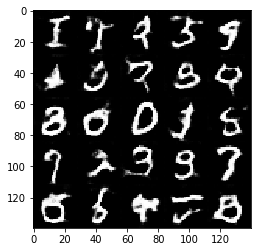

Epoch 2/2... Batch 410/468.75... Discriminator Loss: 1.0023... Generator Loss: 1.5983
Epoch 2/2... Batch 420/468.75... Discriminator Loss: 1.1241... Generator Loss: 0.7462
Epoch 2/2... Batch 430/468.75... Discriminator Loss: 0.9356... Generator Loss: 1.3568
Epoch 2/2... Batch 440/468.75... Discriminator Loss: 0.9852... Generator Loss: 1.1246
Epoch 2/2... Batch 450/468.75... Discriminator Loss: 1.0759... Generator Loss: 1.8152
Epoch 2/2... Batch 460/468.75... Discriminator Loss: 1.0561... Generator Loss: 0.7985


In [17]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10/1582.8046875... Discriminator Loss: 0.8401... Generator Loss: 1.1797
Epoch 1/1... Batch 20/1582.8046875... Discriminator Loss: 0.7162... Generator Loss: 1.4897
Epoch 1/1... Batch 30/1582.8046875... Discriminator Loss: 0.6370... Generator Loss: 1.7645
Epoch 1/1... Batch 40/1582.8046875... Discriminator Loss: 0.5672... Generator Loss: 2.0589
Epoch 1/1... Batch 50/1582.8046875... Discriminator Loss: 0.5401... Generator Loss: 2.0896
Epoch 1/1... Batch 60/1582.8046875... Discriminator Loss: 0.5084... Generator Loss: 2.4038
Epoch 1/1... Batch 70/1582.8046875... Discriminator Loss: 0.5590... Generator Loss: 2.1872
Epoch 1/1... Batch 80/1582.8046875... Discriminator Loss: 0.5612... Generator Loss: 2.4283
Epoch 1/1... Batch 90/1582.8046875... Discriminator Loss: 0.6578... Generator Loss: 1.6664
Epoch 1/1... Batch 100/1582.8046875... Discriminator Loss: 0.6012... Generator Loss: 2.5681


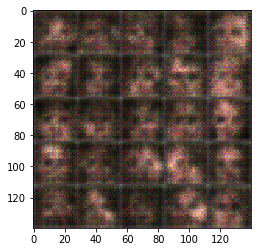

Epoch 1/1... Batch 110/1582.8046875... Discriminator Loss: 0.6838... Generator Loss: 1.5042
Epoch 1/1... Batch 120/1582.8046875... Discriminator Loss: 0.6528... Generator Loss: 1.7954
Epoch 1/1... Batch 130/1582.8046875... Discriminator Loss: 0.6883... Generator Loss: 2.1775
Epoch 1/1... Batch 140/1582.8046875... Discriminator Loss: 1.0072... Generator Loss: 1.0056
Epoch 1/1... Batch 150/1582.8046875... Discriminator Loss: 0.5901... Generator Loss: 2.0875
Epoch 1/1... Batch 160/1582.8046875... Discriminator Loss: 0.8076... Generator Loss: 1.5047
Epoch 1/1... Batch 170/1582.8046875... Discriminator Loss: 0.8727... Generator Loss: 1.6395
Epoch 1/1... Batch 180/1582.8046875... Discriminator Loss: 0.6721... Generator Loss: 1.9485
Epoch 1/1... Batch 190/1582.8046875... Discriminator Loss: 0.8214... Generator Loss: 1.6360
Epoch 1/1... Batch 200/1582.8046875... Discriminator Loss: 0.9882... Generator Loss: 1.3122


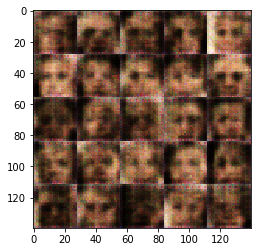

Epoch 1/1... Batch 210/1582.8046875... Discriminator Loss: 0.7612... Generator Loss: 1.9933
Epoch 1/1... Batch 220/1582.8046875... Discriminator Loss: 0.9086... Generator Loss: 1.2595
Epoch 1/1... Batch 230/1582.8046875... Discriminator Loss: 0.8257... Generator Loss: 1.3757
Epoch 1/1... Batch 240/1582.8046875... Discriminator Loss: 0.7388... Generator Loss: 1.8025
Epoch 1/1... Batch 250/1582.8046875... Discriminator Loss: 0.7301... Generator Loss: 1.7058
Epoch 1/1... Batch 260/1582.8046875... Discriminator Loss: 0.7869... Generator Loss: 1.3971
Epoch 1/1... Batch 270/1582.8046875... Discriminator Loss: 0.8054... Generator Loss: 1.2685
Epoch 1/1... Batch 280/1582.8046875... Discriminator Loss: 0.6724... Generator Loss: 1.8816
Epoch 1/1... Batch 290/1582.8046875... Discriminator Loss: 0.7603... Generator Loss: 1.6361
Epoch 1/1... Batch 300/1582.8046875... Discriminator Loss: 0.8627... Generator Loss: 1.1631


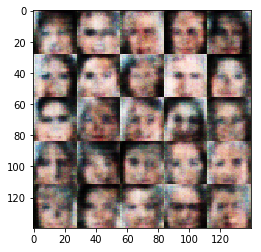

Epoch 1/1... Batch 310/1582.8046875... Discriminator Loss: 0.8428... Generator Loss: 1.6241
Epoch 1/1... Batch 320/1582.8046875... Discriminator Loss: 0.7975... Generator Loss: 1.5387
Epoch 1/1... Batch 330/1582.8046875... Discriminator Loss: 0.8340... Generator Loss: 1.8320
Epoch 1/1... Batch 340/1582.8046875... Discriminator Loss: 0.8607... Generator Loss: 1.7822
Epoch 1/1... Batch 350/1582.8046875... Discriminator Loss: 0.7180... Generator Loss: 1.7233
Epoch 1/1... Batch 360/1582.8046875... Discriminator Loss: 0.7944... Generator Loss: 2.0680
Epoch 1/1... Batch 370/1582.8046875... Discriminator Loss: 0.7670... Generator Loss: 1.5243
Epoch 1/1... Batch 380/1582.8046875... Discriminator Loss: 0.7851... Generator Loss: 1.3209
Epoch 1/1... Batch 390/1582.8046875... Discriminator Loss: 0.7754... Generator Loss: 1.3516
Epoch 1/1... Batch 400/1582.8046875... Discriminator Loss: 0.8234... Generator Loss: 1.4356


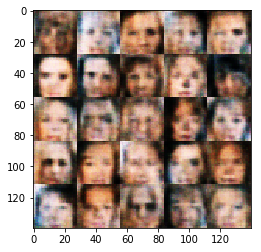

Epoch 1/1... Batch 410/1582.8046875... Discriminator Loss: 0.7930... Generator Loss: 1.4971
Epoch 1/1... Batch 420/1582.8046875... Discriminator Loss: 0.6772... Generator Loss: 1.6003
Epoch 1/1... Batch 430/1582.8046875... Discriminator Loss: 0.7683... Generator Loss: 1.6786
Epoch 1/1... Batch 440/1582.8046875... Discriminator Loss: 0.7743... Generator Loss: 1.7574
Epoch 1/1... Batch 450/1582.8046875... Discriminator Loss: 0.7478... Generator Loss: 2.0572
Epoch 1/1... Batch 460/1582.8046875... Discriminator Loss: 0.8230... Generator Loss: 1.3564
Epoch 1/1... Batch 470/1582.8046875... Discriminator Loss: 0.7686... Generator Loss: 1.3400
Epoch 1/1... Batch 480/1582.8046875... Discriminator Loss: 0.7357... Generator Loss: 1.5760
Epoch 1/1... Batch 490/1582.8046875... Discriminator Loss: 0.7008... Generator Loss: 1.8738
Epoch 1/1... Batch 500/1582.8046875... Discriminator Loss: 0.7239... Generator Loss: 1.6877


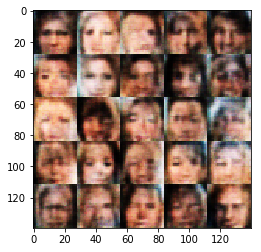

Epoch 1/1... Batch 510/1582.8046875... Discriminator Loss: 0.7023... Generator Loss: 1.5336
Epoch 1/1... Batch 520/1582.8046875... Discriminator Loss: 0.7287... Generator Loss: 1.7338
Epoch 1/1... Batch 530/1582.8046875... Discriminator Loss: 1.5081... Generator Loss: 0.5295
Epoch 1/1... Batch 540/1582.8046875... Discriminator Loss: 0.7695... Generator Loss: 1.6726
Epoch 1/1... Batch 550/1582.8046875... Discriminator Loss: 0.8081... Generator Loss: 1.4086
Epoch 1/1... Batch 560/1582.8046875... Discriminator Loss: 0.7362... Generator Loss: 1.8065
Epoch 1/1... Batch 570/1582.8046875... Discriminator Loss: 0.8149... Generator Loss: 2.1889
Epoch 1/1... Batch 580/1582.8046875... Discriminator Loss: 0.7240... Generator Loss: 1.5602
Epoch 1/1... Batch 590/1582.8046875... Discriminator Loss: 0.9872... Generator Loss: 0.9010
Epoch 1/1... Batch 600/1582.8046875... Discriminator Loss: 0.8307... Generator Loss: 1.3517


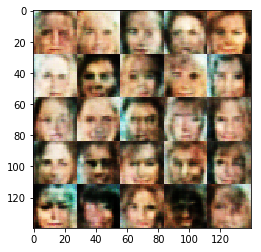

Epoch 1/1... Batch 610/1582.8046875... Discriminator Loss: 0.7808... Generator Loss: 1.3886
Epoch 1/1... Batch 620/1582.8046875... Discriminator Loss: 0.8846... Generator Loss: 1.0844
Epoch 1/1... Batch 630/1582.8046875... Discriminator Loss: 0.8209... Generator Loss: 1.5330
Epoch 1/1... Batch 640/1582.8046875... Discriminator Loss: 0.7325... Generator Loss: 1.7003
Epoch 1/1... Batch 650/1582.8046875... Discriminator Loss: 0.7566... Generator Loss: 1.3512
Epoch 1/1... Batch 660/1582.8046875... Discriminator Loss: 0.6964... Generator Loss: 1.9058
Epoch 1/1... Batch 670/1582.8046875... Discriminator Loss: 0.8788... Generator Loss: 1.0921
Epoch 1/1... Batch 680/1582.8046875... Discriminator Loss: 1.0044... Generator Loss: 2.3638
Epoch 1/1... Batch 690/1582.8046875... Discriminator Loss: 0.8722... Generator Loss: 1.3213
Epoch 1/1... Batch 700/1582.8046875... Discriminator Loss: 0.8796... Generator Loss: 2.1939


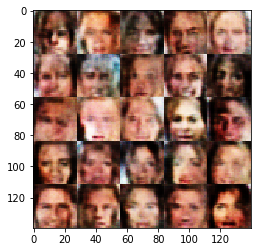

Epoch 1/1... Batch 710/1582.8046875... Discriminator Loss: 0.8084... Generator Loss: 1.4706
Epoch 1/1... Batch 720/1582.8046875... Discriminator Loss: 0.7482... Generator Loss: 1.7400
Epoch 1/1... Batch 730/1582.8046875... Discriminator Loss: 0.7434... Generator Loss: 1.7737
Epoch 1/1... Batch 740/1582.8046875... Discriminator Loss: 0.9602... Generator Loss: 1.2597
Epoch 1/1... Batch 750/1582.8046875... Discriminator Loss: 1.0649... Generator Loss: 0.8037
Epoch 1/1... Batch 760/1582.8046875... Discriminator Loss: 0.8426... Generator Loss: 1.3267
Epoch 1/1... Batch 770/1582.8046875... Discriminator Loss: 0.8266... Generator Loss: 1.4171
Epoch 1/1... Batch 780/1582.8046875... Discriminator Loss: 1.1462... Generator Loss: 0.7627
Epoch 1/1... Batch 790/1582.8046875... Discriminator Loss: 0.9776... Generator Loss: 0.9391
Epoch 1/1... Batch 800/1582.8046875... Discriminator Loss: 1.0964... Generator Loss: 1.7376


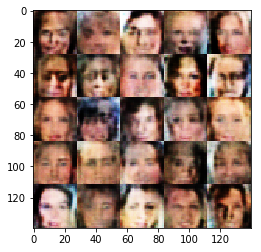

Epoch 1/1... Batch 810/1582.8046875... Discriminator Loss: 0.8826... Generator Loss: 1.2060
Epoch 1/1... Batch 820/1582.8046875... Discriminator Loss: 0.9904... Generator Loss: 0.9895
Epoch 1/1... Batch 830/1582.8046875... Discriminator Loss: 0.8561... Generator Loss: 1.1411
Epoch 1/1... Batch 840/1582.8046875... Discriminator Loss: 1.3040... Generator Loss: 0.7884
Epoch 1/1... Batch 850/1582.8046875... Discriminator Loss: 0.8765... Generator Loss: 1.2134
Epoch 1/1... Batch 860/1582.8046875... Discriminator Loss: 0.8809... Generator Loss: 1.1416
Epoch 1/1... Batch 870/1582.8046875... Discriminator Loss: 0.9700... Generator Loss: 1.0161
Epoch 1/1... Batch 880/1582.8046875... Discriminator Loss: 0.9131... Generator Loss: 1.4237
Epoch 1/1... Batch 890/1582.8046875... Discriminator Loss: 1.1667... Generator Loss: 0.7095
Epoch 1/1... Batch 900/1582.8046875... Discriminator Loss: 0.8425... Generator Loss: 1.3655


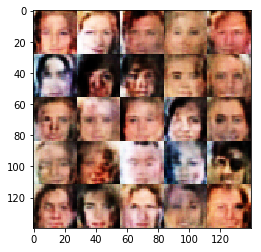

Epoch 1/1... Batch 910/1582.8046875... Discriminator Loss: 0.9966... Generator Loss: 1.0419
Epoch 1/1... Batch 920/1582.8046875... Discriminator Loss: 0.7647... Generator Loss: 1.4448
Epoch 1/1... Batch 930/1582.8046875... Discriminator Loss: 1.3103... Generator Loss: 0.5669
Epoch 1/1... Batch 940/1582.8046875... Discriminator Loss: 0.6982... Generator Loss: 1.6968
Epoch 1/1... Batch 950/1582.8046875... Discriminator Loss: 1.0647... Generator Loss: 0.9797
Epoch 1/1... Batch 960/1582.8046875... Discriminator Loss: 0.9062... Generator Loss: 1.4726
Epoch 1/1... Batch 970/1582.8046875... Discriminator Loss: 0.8292... Generator Loss: 1.6004
Epoch 1/1... Batch 980/1582.8046875... Discriminator Loss: 1.0838... Generator Loss: 0.8123
Epoch 1/1... Batch 990/1582.8046875... Discriminator Loss: 0.8615... Generator Loss: 1.2536
Epoch 1/1... Batch 1000/1582.8046875... Discriminator Loss: 1.0087... Generator Loss: 1.6173


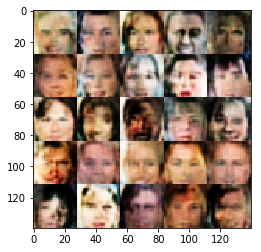

Epoch 1/1... Batch 1010/1582.8046875... Discriminator Loss: 0.9562... Generator Loss: 1.5857
Epoch 1/1... Batch 1020/1582.8046875... Discriminator Loss: 1.0752... Generator Loss: 1.7340
Epoch 1/1... Batch 1030/1582.8046875... Discriminator Loss: 0.8640... Generator Loss: 1.2098
Epoch 1/1... Batch 1040/1582.8046875... Discriminator Loss: 0.9152... Generator Loss: 1.6376
Epoch 1/1... Batch 1050/1582.8046875... Discriminator Loss: 0.8619... Generator Loss: 1.5885
Epoch 1/1... Batch 1060/1582.8046875... Discriminator Loss: 1.0841... Generator Loss: 1.5851
Epoch 1/1... Batch 1070/1582.8046875... Discriminator Loss: 1.1345... Generator Loss: 0.6972
Epoch 1/1... Batch 1080/1582.8046875... Discriminator Loss: 0.9068... Generator Loss: 1.1866
Epoch 1/1... Batch 1090/1582.8046875... Discriminator Loss: 1.0966... Generator Loss: 0.7898
Epoch 1/1... Batch 1100/1582.8046875... Discriminator Loss: 1.4382... Generator Loss: 0.4948


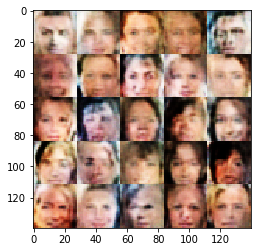

Epoch 1/1... Batch 1110/1582.8046875... Discriminator Loss: 0.9020... Generator Loss: 1.1961
Epoch 1/1... Batch 1120/1582.8046875... Discriminator Loss: 0.9311... Generator Loss: 1.4431
Epoch 1/1... Batch 1130/1582.8046875... Discriminator Loss: 0.9934... Generator Loss: 2.4262
Epoch 1/1... Batch 1140/1582.8046875... Discriminator Loss: 0.8220... Generator Loss: 1.7972
Epoch 1/1... Batch 1150/1582.8046875... Discriminator Loss: 0.8904... Generator Loss: 2.2377
Epoch 1/1... Batch 1160/1582.8046875... Discriminator Loss: 0.7843... Generator Loss: 1.5506
Epoch 1/1... Batch 1170/1582.8046875... Discriminator Loss: 1.2050... Generator Loss: 1.9494
Epoch 1/1... Batch 1180/1582.8046875... Discriminator Loss: 0.8322... Generator Loss: 1.4971
Epoch 1/1... Batch 1190/1582.8046875... Discriminator Loss: 0.8612... Generator Loss: 1.1387
Epoch 1/1... Batch 1200/1582.8046875... Discriminator Loss: 1.1701... Generator Loss: 1.5084


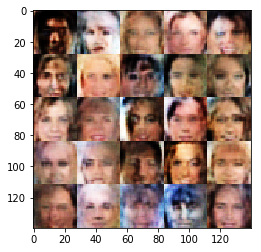

Epoch 1/1... Batch 1210/1582.8046875... Discriminator Loss: 0.9549... Generator Loss: 1.5521
Epoch 1/1... Batch 1220/1582.8046875... Discriminator Loss: 1.2985... Generator Loss: 0.5965
Epoch 1/1... Batch 1230/1582.8046875... Discriminator Loss: 0.7971... Generator Loss: 1.6976
Epoch 1/1... Batch 1240/1582.8046875... Discriminator Loss: 0.7592... Generator Loss: 1.9616
Epoch 1/1... Batch 1250/1582.8046875... Discriminator Loss: 0.9447... Generator Loss: 1.1247
Epoch 1/1... Batch 1260/1582.8046875... Discriminator Loss: 1.1702... Generator Loss: 0.7644
Epoch 1/1... Batch 1270/1582.8046875... Discriminator Loss: 0.9888... Generator Loss: 1.2440
Epoch 1/1... Batch 1280/1582.8046875... Discriminator Loss: 1.0902... Generator Loss: 0.8744
Epoch 1/1... Batch 1290/1582.8046875... Discriminator Loss: 0.8977... Generator Loss: 1.3525
Epoch 1/1... Batch 1300/1582.8046875... Discriminator Loss: 1.3145... Generator Loss: 0.5796


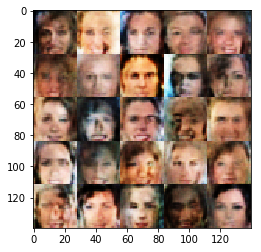

Epoch 1/1... Batch 1310/1582.8046875... Discriminator Loss: 0.9874... Generator Loss: 1.2190
Epoch 1/1... Batch 1320/1582.8046875... Discriminator Loss: 0.9582... Generator Loss: 1.4270
Epoch 1/1... Batch 1330/1582.8046875... Discriminator Loss: 1.0224... Generator Loss: 1.2981
Epoch 1/1... Batch 1340/1582.8046875... Discriminator Loss: 1.0511... Generator Loss: 0.9073
Epoch 1/1... Batch 1350/1582.8046875... Discriminator Loss: 0.9663... Generator Loss: 1.0656
Epoch 1/1... Batch 1360/1582.8046875... Discriminator Loss: 0.9454... Generator Loss: 1.2629
Epoch 1/1... Batch 1370/1582.8046875... Discriminator Loss: 0.7956... Generator Loss: 1.3464
Epoch 1/1... Batch 1380/1582.8046875... Discriminator Loss: 1.0361... Generator Loss: 0.8785
Epoch 1/1... Batch 1390/1582.8046875... Discriminator Loss: 0.9313... Generator Loss: 1.4105
Epoch 1/1... Batch 1400/1582.8046875... Discriminator Loss: 1.1502... Generator Loss: 0.7381


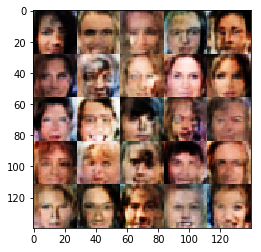

Epoch 1/1... Batch 1410/1582.8046875... Discriminator Loss: 0.8789... Generator Loss: 1.4317
Epoch 1/1... Batch 1420/1582.8046875... Discriminator Loss: 1.2551... Generator Loss: 1.7112
Epoch 1/1... Batch 1430/1582.8046875... Discriminator Loss: 1.3274... Generator Loss: 0.5591
Epoch 1/1... Batch 1440/1582.8046875... Discriminator Loss: 1.1011... Generator Loss: 0.9350
Epoch 1/1... Batch 1450/1582.8046875... Discriminator Loss: 0.8689... Generator Loss: 1.2642
Epoch 1/1... Batch 1460/1582.8046875... Discriminator Loss: 0.9773... Generator Loss: 1.8535
Epoch 1/1... Batch 1470/1582.8046875... Discriminator Loss: 0.9837... Generator Loss: 1.0398
Epoch 1/1... Batch 1480/1582.8046875... Discriminator Loss: 1.0324... Generator Loss: 0.8225
Epoch 1/1... Batch 1490/1582.8046875... Discriminator Loss: 1.1096... Generator Loss: 0.8631
Epoch 1/1... Batch 1500/1582.8046875... Discriminator Loss: 1.2294... Generator Loss: 0.7022


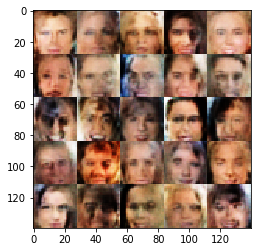

Epoch 1/1... Batch 1510/1582.8046875... Discriminator Loss: 0.8519... Generator Loss: 1.2949
Epoch 1/1... Batch 1520/1582.8046875... Discriminator Loss: 0.8433... Generator Loss: 1.7838
Epoch 1/1... Batch 1530/1582.8046875... Discriminator Loss: 1.3178... Generator Loss: 1.7889
Epoch 1/1... Batch 1540/1582.8046875... Discriminator Loss: 0.9331... Generator Loss: 1.1723
Epoch 1/1... Batch 1550/1582.8046875... Discriminator Loss: 1.1673... Generator Loss: 2.1216
Epoch 1/1... Batch 1560/1582.8046875... Discriminator Loss: 0.8435... Generator Loss: 1.2211
Epoch 1/1... Batch 1570/1582.8046875... Discriminator Loss: 1.5273... Generator Loss: 0.4882
Epoch 1/1... Batch 1580/1582.8046875... Discriminator Loss: 1.1396... Generator Loss: 0.7998


In [18]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.